In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib as joblib

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DS4A-Project/Data/political_news/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(path + 'BERT_data2.csv')

In [ ]:
df.head() # 1 indicates FAKE, 0 indicates REAL

,subject,fake_flag,title_text_BERT
0,News,1,Donald Trump Sends Out Embarrassing New Year’...
1,News,1,Drunk Bragging Trump Staffer Started Russian ...
2,News,1,Sheriff David Clarke Becomes An Internet Joke...
3,News,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,News,1,Pope Francis Just Called Out Donald Trump Dur...


In [ ]:
#df.fake_flag = df.fake_flag.astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subject          44898 non-null  object
 1   fake_flag        44898 non-null  int64 
 2   title_text_BERT  44898 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [ ]:
# construct X and y
X = df.title_text_BERT.apply(lambda x: x.split())
y = df.fake_flag.values

In [ ]:
df.fake_flag.value_counts()

1    23481
0    21417
Name: fake_flag, dtype: int64

In [ ]:
# tokenizeration for embedding layer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
joblib.dump(tokenizer,'/content/drive/My Drive/DS4A-Project/Code/rnn_tokenizer.joblib' )

['/content/drive/My Drive/DS4A-Project/Code/rnn_tokenizer.joblib']

In [ ]:
vocab_size = len(set(chain(*X)))
embedding_dim = 100
#max_length = len(max(X,key=len))
max_length = 700

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [ ]:
X_train.shape

(35918, 700)

In [ ]:
#Simple RNN
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length))
#rnn 
model.add(SimpleRNN(units=128))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 100)          34203200  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 34,232,641
Trainable params: 34,232,641
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128, verbose=1)

# evaluate the model on the test set
scores = model.evaluate(X_test, y_test)

Epoch 1/5
281/281 [==============================] - 255s 906ms/step - loss: 0.6031 - accuracy: 0.6675 - val_loss: 0.5530 - val_accuracy: 0.7208
Epoch 2/5
281/281 [==============================] - 259s 921ms/step - loss: 0.4853 - accuracy: 0.7889 - val_loss: 0.5391 - val_accuracy: 0.7344
Epoch 3/5
281/281 [==============================] - 257s 913ms/step - loss: 0.4280 - accuracy: 0.8037 - val_loss: 0.5354 - val_accuracy: 0.7321
Epoch 4/5
281/281 [==============================] - 258s 919ms/step - loss: 0.3914 - accuracy: 0.8208 - val_loss: 0.5240 - val_accuracy: 0.7575
Epoch 5/5
281/281 [==============================] - 16s 58ms/step - loss: 0.5465 - accuracy: 0.8006


In [ ]:
for layer in model.layers:
    print(layer.output_shape)

(None, 700, 100)
(None, 128)
(None, 1)


In [ ]:
#from keras.models import load_model

model.save('/content/drive/My Drive/DS4A-Project/Code/rnn_model.h5')  # creates a HDF5 file 
# del model  # deletes the existing model

# returns a compiled model identical to the previous one
#model = load_model('/content/drive/My Drive/DS4A-Project/Code/rnn_model.h5')

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int")
print(classification_report(y_test.astype("int"), y_pred))

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      4247
           1       0.74      0.96      0.84      4733

    accuracy                           0.80      8980
   macro avg       0.84      0.79      0.79      8980
weighted avg       0.83      0.80      0.79      8980



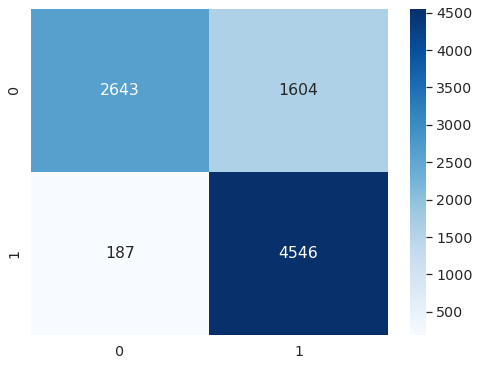

In [ ]:
cm = confusion_matrix(y_test.astype("int"), y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))

plt.figure(figsize=(8,6))
sns.set(font_scale=1.3)
sns.heatmap(df_cm, annot=True, cmap='Blues',fmt='g')
plt.savefig('rnn.png');